<a href="https://colab.research.google.com/github/GailB-ca/digital-display-reader/blob/main/Digit_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import pickle
import numpy as np
from matplotlib import pyplot as plt

from google.colab import drive


In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
with tf.compat.v1.Session(config=config):
    pass  # init sessin with allow_growth


In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [13]:
import lhl_build_dataframe as lhl
import importlib
importlib.reload(lhl)

<module 'lhl_build_dataframe' from '/content/drive/MyDrive/Colab Notebooks/lhl_build_dataframe.py'>

In [8]:
filename = "/content/drive/MyDrive/Colab Notebooks/training_df.pk"
training_numbers_df = pickle.load(open(filename, 'rb'))

In [ ]:
training_numbers_df.head()

,box_order,class,image_id,image_path,xmax,xmin,ymax,ymin,width,height,portrait,img_num_arr,img_num_bw_arr,img_num_width,img_num_height,img_num_arr_resize,class_arr
0,0.0,1,0.0,/Users/gbishop/lighthouse/data_bootcamp/digita...,2166,1740,2070,1799,426,271,0,"[[[221, 208, 210], [221, 208, 210], [221, 208,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",271,426,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",[1]
1,1.0,5,0.0,/Users/gbishop/lighthouse/data_bootcamp/digita...,2186,1710,1775,1514,476,261,0,"[[[38, 51, 49], [38, 51, 49], [37, 50, 48], [3...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",261,476,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",[5]
2,2.0,0,0.0,/Users/gbishop/lighthouse/data_bootcamp/digita...,2131,1690,1535,1194,441,341,0,"[[[36, 50, 48], [35, 49, 47], [36, 50, 48], [3...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",341,441,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",[0]
3,3.0,9,0.0,/Users/gbishop/lighthouse/data_bootcamp/digita...,2661,2165,1785,1469,496,316,0,"[[[46, 63, 60], [44, 61, 58], [48, 65, 62], [4...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",316,496,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",[9]
4,4.0,4,0.0,/Users/gbishop/lighthouse/data_bootcamp/digita...,2601,2135,1455,1154,466,301,0,"[[[55, 72, 68], [55, 72, 68], [55, 72, 68], [5...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",301,466,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",[4]


In [14]:
training_numbers_df['img_process_arr'] = training_numbers_df.apply(
    (lambda x: lhl.get_process_image_digit_array(x))
, axis=1)

In [16]:
training_numbers_df['img_inv_arr'] = training_numbers_df.apply(
    (lambda x: lhl.get_inv_image_digit_array(x))
, axis=1)

In [17]:
training_numbers_df['img_bw_arr'] = training_numbers_df.apply(
    (lambda x: lhl.get_bw_image_digit_array(x))
, axis=1)

In [18]:
training_numbers_df['img_inv_arr_resize'] = training_numbers_df.apply(
    (lambda x: lhl.resize_with_distortion(x, 'img_inv_arr', 400, 600))
, axis=1)

In [22]:
training_numbers_df['class_arr'] = training_numbers_df.apply(
    (lambda x: lhl.class_to_array(x))
, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


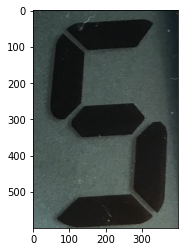

In [46]:
plt.imshow(training_numbers_df.loc[232]['img_inv_arr_resize'], cmap="gray")
plt.show()


In [72]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
    #rescale=1/255.0,
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=2,
    zoom_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    horizontal_flip=False,
    fill_mode="nearest", # Flip back to this when black box issue is fixed
    #fill_mode="constant",
    cval=255,
    validation_split=0.2)

testAug = ImageDataGenerator(
    #rescale=1/255.0
    samplewise_center=True,
    samplewise_std_normalization=True    
    )

In [69]:
# Shuffle the rows
from sklearn.utils import shuffle
training_numbers_df = shuffle(training_numbers_df)

In [ ]:
for i in range(11,20):
    image = training_numbers_df.loc[i]['img_inv_arr_resize']
    plt.imshow(image, cmap="gray")
    plt.show() 

In [25]:
X = np.array(training_numbers_df['img_inv_arr_resize'].values.tolist())
Y = np.array(training_numbers_df['class_arr'].values.tolist())

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [27]:
X_train = tf.keras.applications.resnet50.preprocess_input(X_train)
Y_train = tf.keras.utils.to_categorical(Y_train)

X_test = tf.keras.applications.resnet50.preprocess_input(X_test)
Y_test = tf.keras.utils.to_categorical(Y_test)

In [28]:
#learning_rate = 1e-6 # poor performance
learning_rate = 1e-4
#learning_rate = 1e-2 # Poor performance
#num_epochs = 10 # good performance
#num_epochs = 64 # Poor performance
num_epochs = 16

batch_size = 16 # good performance for basemodel
#batch_size=32 # Words for model2

img_shape = (600, 400, 3)

In [73]:
trainGen = trainAug.flow(X_train, Y_train, batch_size=batch_size, subset="training", shuffle=True)
valGen = trainAug.flow(X_train, Y_train, batch_size=batch_size, subset="validation", shuffle=True)
testGen = testAug.flow(X_test, Y_test, batch_size=batch_size)

In [54]:
print("Size of Training Data: ", trainGen.n)

Size of Training Data:  1402


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


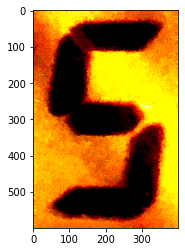

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


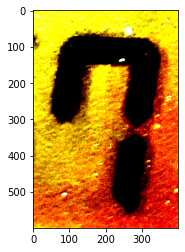

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


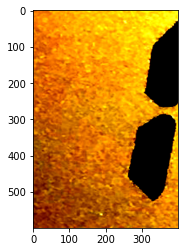

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


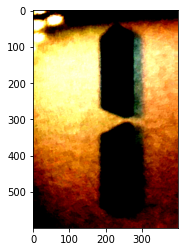

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


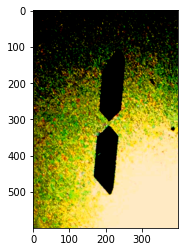

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


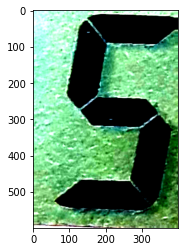

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


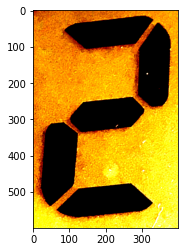

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


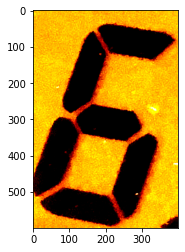

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


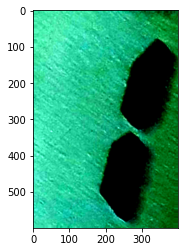

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


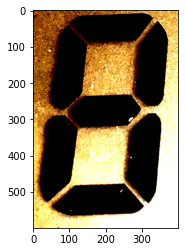

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


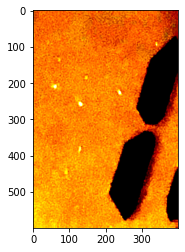

In [74]:
x,y = trainGen.next()

for i in range(0,11):
    image = x[i]
    plt.imshow(image, cmap="gray")
    plt.show()    

In [75]:
# VERSION 1
baseModel = ResNet50(weights=None, include_top=True,
                    input_tensor=Input(shape=img_shape),
                    classes=10)


In [ ]:
# VERSION 2
#from keras.layers import Dense, GlobalAveragePooling2D
#from keras.models import Model

#base_model = ResNet50(weights='imagenet', include_top=False,
#                             input_tensor=Input(shape=img_shape))

# Taking the output of the last convolution block in ResNet50
#x = base_model.output
 
# Adding a Global Average Pooling layer
#x = GlobalAveragePooling2D()(x)
 
# Adding a fully connected layer having 1024 neurons
#x = Dense(1024, activation='relu')(x)
 
# Adding a fully connected layer having 10 neurons which will
# give the probability of image having digits 0 to 10
#predictions = Dense(10, activation='softmax')(x)
 
# Model to be trained
#baseModel = Model(inputs=base_model.input, outputs=predictions)
 
# Training only top layers i.e. the layers which we have added in the end
#for layer in base_model.layers:
#    layer.trainable = False


In [ ]:
# VERSION 3
classifier_vgg16 = VGG16(
    input_shape = img_shape,
    include_top = False,
    weights = 'imagenet')
classifier_resnet = ResNet50(
    input_shape = img_shape,
    include_top = False,
    weights = 'imagenet')

# Don't train existing weights for vgg16 and resnet50
for layer in classifier_vgg16.layers:
    layer.trainable = False
for layer in classifier_resnet.layers:
    layer.trainable = False

In [ ]:
#VGG16
classifier1 = classifier_vgg16.output#head mode
classifier1 = layers.Flatten()(classifier1)#adding layer of flatten
classifier1 = layers.Dense(units=256, activation='relu')(classifier1)
classifier1 = layers.Dropout(0.6)(classifier1)
classifier1 = layers.Dense(units=10, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#resnet50
classifier2 = classifier_resnet.output#head mode
classifier2 = layers.Flatten()(classifier2)#adding layer of flatten
classifier2 = layers.Dropout(0.6)(classifier2)
classifier2 = layers.Dense(units=10, activation='softmax')(classifier2)

model2 = Model(inputs = classifier_resnet.input , outputs = classifier2)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
#fit the model
#resnet50
history2 = model2.fit(trainGen,
                   steps_per_epoch=trainGen.n // batch_size, 
                   epochs=num_epochs,
                   validation_data=valGen,
                   validation_steps=valGen.n // batch_size,
                   verbose=1)


In [ ]:
history3 = model.fit(trainGen,
                   steps_per_epoch=trainGen.n // batch_size, 
                   epochs=num_epochs,
                   validation_data=valGen,
                   validation_steps=valGen.n // batch_size,
                   verbose=1)

In [76]:
opt = Adam(lr=learning_rate, 
           decay=learning_rate / num_epochs)
baseModel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [34]:
print("Steps per epoch", trainGen.n // batch_size)
print("Number of epochs", num_epochs)
print("Validation data", valGen.n)

Steps per epoch 87
Number of epochs 16
Validation data 350


In [77]:
train_history = baseModel.fit(trainGen,
                   steps_per_epoch=trainGen.n // batch_size, 
                   epochs=num_epochs,
                   validation_data=valGen,
                   validation_steps=valGen.n // batch_size,
                   verbose=1)

Epoch 1/16
87/87 [==============================] - 80s 869ms/step - loss: 2.4015 - accuracy: 0.2372 - val_loss: 2.5020 - val_accuracy: 0.3065
Epoch 2/16
87/87 [==============================] - 75s 858ms/step - loss: 1.2033 - accuracy: 0.5711 - val_loss: 3.5914 - val_accuracy: 0.1905
Epoch 3/16
87/87 [==============================] - 75s 857ms/step - loss: 0.4030 - accuracy: 0.8767 - val_loss: 0.5726 - val_accuracy: 0.7619
Epoch 4/16
87/87 [==============================] - 75s 864ms/step - loss: 0.1290 - accuracy: 0.9736 - val_loss: 0.7275 - val_accuracy: 0.7560
Epoch 5/16
87/87 [==============================] - 75s 856ms/step - loss: 0.0784 - accuracy: 0.9806 - val_loss: 0.1816 - val_accuracy: 0.9554
Epoch 6/16
87/87 [==============================] - 75s 865ms/step - loss: 0.0852 - accuracy: 0.9809 - val_loss: 0.1599 - val_accuracy: 0.9494
Epoch 7/16
87/87 [==============================] - 75s 857ms/step - loss: 0.0293 - accuracy: 0.9961 - val_loss: 0.1912 - val_accuracy: 0.9702

In [ ]:
# VERSION 2 - fit it again
for layer in base_model.layers[0:143]:
  layer.trainable = False
 
for layer in base_model.layers[143:]:
  layer.trainable = True

In [ ]:
train_history = baseModel.fit(trainGen,
                   steps_per_epoch=trainGen.n // batch_size, 
                   epochs=num_epochs,
                   validation_data=valGen,
                   validation_steps=valGen.n // batch_size,
                   verbose=1)

Epoch 1/10
43/43 [==============================] - 44s 1s/step - loss: 2.2874 - accuracy: 0.1977 - val_loss: 2.2439 - val_accuracy: 0.1875
Epoch 2/10
43/43 [==============================] - 43s 1s/step - loss: 2.2565 - accuracy: 0.2150 - val_loss: 2.3044 - val_accuracy: 0.2000
Epoch 3/10
43/43 [==============================] - 43s 1s/step - loss: 2.2691 - accuracy: 0.2253 - val_loss: 2.4765 - val_accuracy: 0.1375
Epoch 4/10
43/43 [==============================] - 43s 999ms/step - loss: 2.2717 - accuracy: 0.2003 - val_loss: 2.2193 - val_accuracy: 0.2062
Epoch 5/10
43/43 [==============================] - 43s 1s/step - loss: 2.2379 - accuracy: 0.2430 - val_loss: 2.4993 - val_accuracy: 0.2062
Epoch 6/10
43/43 [==============================] - 43s 1s/step - loss: 2.2736 - accuracy: 0.2224 - val_loss: 2.2062 - val_accuracy: 0.2313
Epoch 7/10
43/43 [==============================] - 43s 1s/step - loss: 2.2722 - accuracy: 0.2003 - val_loss: 2.2371 - val_accuracy: 0.2313
Epoch 8/10
43/43 

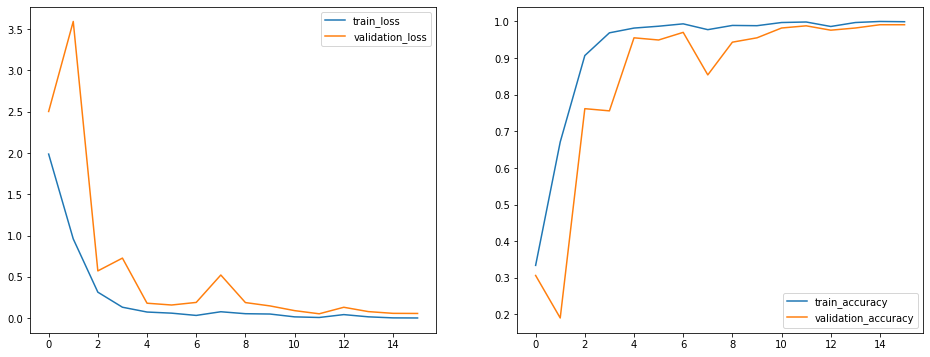

In [82]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[16,6])
ax1.plot(train_history.history['loss'], label='train_loss')
ax1.plot(train_history.history['val_loss'], label='validation_loss')
ax1.legend()
ax2.plot(train_history.history['accuracy'], label='train_accuracy')
ax2.plot(train_history.history['val_accuracy'], label='validation_accuracy')
ax2.legend();

In [78]:
testGen.reset()
predIdxs = baseModel.predict(
    testGen,
	  steps=(testGen.n // batch_size) + 1)

In [ ]:
# VERSION 3
testGen.reset()
predIdxs = model2.predict(
    testGen,
	  steps=(testGen.n // batch_size) + 1)


In [79]:
print(predIdxs)
predIdxs = np.argmax(predIdxs, axis=1)

[[3.6171449e-10 9.9511188e-01 3.2192954e-06 ... 4.3222490e-03
  5.3658439e-11 2.0001499e-07]
 [9.9945194e-01 2.0627587e-05 7.0983822e-07 ... 1.5810088e-04
  3.1826430e-04 3.9273605e-06]
 [9.6382545e-03 4.4483049e-06 3.1997573e-05 ... 1.6291652e-04
  9.7480923e-01 6.6469619e-03]
 ...
 [1.1910994e-05 1.2821142e-04 9.2422461e-09 ... 1.2984025e-05
  1.1346592e-06 5.1433395e-04]
 [1.4857643e-06 2.3558579e-08 7.3711863e-06 ... 2.5120216e-05
  1.9507006e-05 9.9492621e-01]
 [2.1559247e-10 9.9976557e-01 7.3280724e-08 ... 2.1902373e-04
  2.4912708e-10 1.8490246e-08]]


In [80]:
from sklearn.metrics import classification_report
print(predIdxs)
Y_expected = np.argmax(Y_test, axis=1)
print(Y_expected)
print(classification_report(Y_expected, predIdxs, zero_division=0))	

[1 0 8 9 1 9 1 2 2 8 5 5 1 5 2 8 1 7 3 0 4 8 7 7 1 9 1 6 1 1 2 7 8 1 6 2 7
 6 5 3 1 6 1 8 7 7 1 8 5 1 1 8 4 7 1 2 6 8 2 7 1 6 7 4 2 5 1 1 3 1 7 4 6 4
 6 1 7 4 1 7 3 1 3 1 0 8 4 4 6 1 4 5 4 3 6 4 5 4 5 4 6 6 2 8 9 6 1 6 6 7 1
 1 2 5 7 8 4 4 4 8 5 1 1 6 0 7 4 0 6 1 9 9 8 6 3 1 7 6 2 3 6 3 9 5 6 6 9 7
 8 7 8 3 6 7 6 2 1 4 0 8 1 1 1 1 1 7 4 7 9 7 9 8 9 1 6 3 1 5 7 7 3 3 7 1 1
 1 9 6 2 9 0 2 6 4 1 6 4 8 6 7 1 4 1 5 2 1 9 5 7 0 9 6 1 1 1 5 5 0 8 7 9 1
 1 7 1 8 9 4 8 7 6 7 8 1 3 7 9 3 8 8 5 5 2 3 4 3 1 5 6 4 1 5 2 7 8 4 6 7 6
 8 7 1 0 6 0 1 7 4 1 9 0 2 0 5 9 9 7 6 1 3 4 0 6 5 8 5 2 0 9 8 8 3 1 0 1 2
 2 7 0 1 1 7 4 6 8 9 6 7 9 2 4 3 1 3 6 0 8 2 1 5 8 5 7 2 3 1 4 7 7 1 6 6 6
 9 2 3 7 7 4 7 9 1 0 0 7 2 5 4 1 7 1 1 2 6 8 3 5 1 9 7 8 6 7 4 6 4 6 1 6 8
 6 1 8 7 0 1 5 1 8 2 4 5 7 1 7 3 7 5 1 6 6 5 6 4 0 5 4 6 2 2 1 3 3 1 8 6 3
 4 5 6 8 1 6 7 4 2 3 0 4 6 1 2 2 6 1 6 1 8 6 2 9 1 5 1 9 4 9 1]
[2 1 1 3 4 0 6 8 7 9 6 3 0 5 0 4 8 1 1 9 6 4 4 6 1 9 5 5 9 4 6 7 7 0 5 0 5
 7 8 4 9 5 1 3 2 1 2 1 4 8 9 9 9 4 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


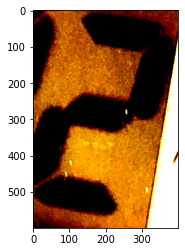

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
4


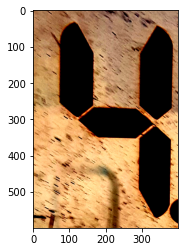

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
0


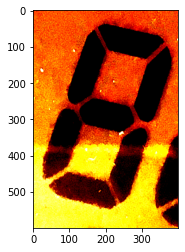

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
6


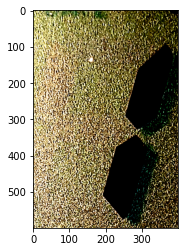

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
8


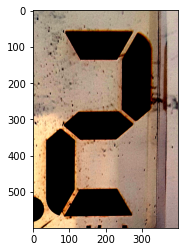

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
7


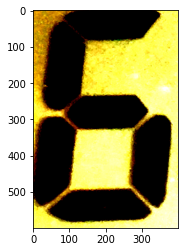

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
9


In [81]:
xtest,ytest = testGen.next()

for i in range(4,10):
    image = xtest[i]
    plt.imshow(image, cmap="gray")
    plt.show()   
    print(ytest[i])
    print(Y_expected[i])